### 0.0 Introduction

#### This notebook uses data scraped from kickstarter by webrobots (found here : https://webrobots.io/kickstarter-datasets/). Performs an exploratory clustering analysis on these data. It uses word2vec to transform the text data in this set into a 7 dimensional vector.

In [1]:
import requests
import random
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np
import scipy
import pickle

### 1.0 Importing Data and Selecting Features.

In [2]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [3]:
pd.set_option('display.max_columns', 1000)

In [4]:
month_folders = ['April2023', 'August2023', 'February2023', 'January2022',
                 'January2023', 'July2023', 'June2023', 'March2023', 'May2023', 'September2023'];

In [5]:
raw_df = pd.DataFrame();

current_paths = [];
for month in month_folders:
    current_paths = current_paths + [join(month, x) for x in listdir(month) if '.csv' in x]

for current_path in current_paths:
    df_temp = pd.read_csv(current_path);
    raw_df = pd.concat([raw_df, df_temp])

raw_df = raw_df.reset_index(drop = True)

In [6]:
raw_df.head(1)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,location,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,friends,is_backing,is_starred,permissions
0,230,I know how difficult it is to gain any experie...,"{""id"":51,""name"":""Software"",""analytics_name"":""S...",11211.0,GB,the United Kingdom,1389127645,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,£,False,USD,1393111179,False,1.238278,1999.0,542567707,False,1390519179,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",Cisco CCNA and CCNA Security for the Real Worl...,"{""key"":""assets/011/631/975/49f72198be90d30752b...",6746.0,"{""id"":839405,""project_id"":839405,""state"":""inac...",cisco-ccna-and-ccna-security-for-the-real-worl...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1393111180,1.648362,"{""web"":{""project"":""https://www.kickstarter.com...",1.661914,11119.847421,international,NaN,NaN,NaN,NaN


In [7]:
df_selected = raw_df[['backers_count', 'blurb',
                      'category', 'country', 'creator',
                      'currency', 'currency_trailing_code',
                      'disable_communication', 'fx_rate',
                      'goal', 'is_starrable', 'name',
                      'pledged', 'slug', 'spotlight',
                      'staff_pick', 'state', 'usd_exchange_rate',
                      'usd_pledged']]

In [8]:
df_selected.loc[:,'category'] = (df_selected.copy()).apply(lambda x : ast.literal_eval(x['category'])['name'], axis = 1)

In [9]:
df_selected.head(1)

,backers_count,blurb,category,country,creator,currency,currency_trailing_code,disable_communication,fx_rate,goal,is_starrable,name,pledged,slug,spotlight,staff_pick,state,usd_exchange_rate,usd_pledged
0,230,I know how difficult it is to gain any experie...,Software,GB,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,False,False,1.238278,1999.0,False,Cisco CCNA and CCNA Security for the Real Worl...,6746.0,cisco-ccna-and-ccna-security-for-the-real-worl...,True,False,successful,1.661914,11119.847421


### 2.0 Word Embedding

##### I am going to create a corpus from the, "name," "slug," and "blub" text fields. Concatenating thiese strings together for each entry will make a sentence for each data point which I will then append into a list that will represent my word corpus.

In [10]:
corpus = [];
corpus_index = []

for index, row in df_selected.iterrows():
    try:
        sentence = [row['name'] + '. ' + row['slug'] + '. ' + row['blurb']];
        corpus = corpus + sentence;
        corpus_index.append(index);
    
    except:
        continue;

In [11]:
with open('kickstarter-sentiment-analysis_corpus.pickle', 'wb') as handle:
    pickle.dump(corpus, handle);

In [12]:
with open('kickstarter-sentiment-analysis_corpus.pickle', 'rb') as handle:
    corpus = pickle.load(handle);

In [13]:
df_corpus = pd.DataFrame({'sentences' : corpus}, index = corpus_index)

In [14]:
df_corpus_processed = df_corpus.copy()
df_corpus_processed.loc[:, 'sentences'] = df_corpus['sentences'].apply(lambda x : simple_preprocess(x))

In [15]:
df_corpus.to_csv('kickstarter-sentiment-analysis_df_corpus.pickle', index = False);
df_corpus = pd.read_csv('kickstarter-sentiment-analysis_df_corpus.pickle');

In [16]:
df_with_sentences = pd.concat([df_selected[['backers_count',
                                         'category',
                                         'fx_rate',
                                         'goal',
                                         'pledged',
                                         'state']].loc[df_corpus.index],df_corpus_processed], axis = 1)

In [17]:
df_with_sentences.head(2)

,backers_count,category,fx_rate,goal,pledged,state,sentences
0,230.0,Software,1.238278,1999.0,6746.0,successful,"[cisco, ccna, and, ccna, security, for, the, r..."
1,34.0,Software,1.238278,200.0,1079.0,successful,"[strong, file, encryption, tool, strong, file,..."


In [18]:
df_with_sentences['goal_usd'] = df_with_sentences['goal'] * df_with_sentences['fx_rate']

In [19]:
df_with_sentences['pledged_usd'] = df_with_sentences['pledged'] * df_with_sentences['fx_rate']

In [21]:
df_with_sentences[['backers_count', 'category', 'fx_rate', 'state', 'sentences', 'goal_usd', 'pledged_usd']].to_csv('./kickstarter-sentiment-analysis_usd-preprocessed-with-sentences.csv', index = False);

In [22]:
df_cluster = df_with_sentences[['backers_count', 'category', 'fx_rate', 'pledged', 'state','goal_usd', 'pledged_usd']]

In [23]:
def map_state_to_number(state_string):
    lookup = {"failed": -3.0,
              "canceled": -2.0,
              "suspended" : -1.0,
              "submitted" : 0.0,
              "started" : 1.0,
              "live" : 2.0,
              "successful" : 3.0};
    try:
        value = lookup[state_string];
    except:
        value = np.nan;
        
    return value;

In [24]:
category_lookup = {}
for index, item in enumerate(list(set(df_with_sentences['category']))):
    category_lookup.update({item: index})

In [25]:
def map_category_to_number(state_string, category_lookup):
    try:
        value = category_lookup[state_string];
    except:
        value = -1.1;
    
    return value

In [26]:
df_cluster_copy = df_cluster.copy()

In [27]:
df_cluster_copy.head(2)

,backers_count,category,fx_rate,pledged,state,goal_usd,pledged_usd
0,230.0,Software,1.238278,6746.0,successful,2475.318022,8353.424400
1,34.0,Software,1.238278,1079.0,successful,247.655630,1336.102124


In [28]:
df_cluster_copy['state'] = df_cluster['state'].apply(lambda x : map_state_to_number(x))

In [29]:
df_cluster_copy['category'] = df_cluster['category'].apply(lambda x : map_category_to_number(x, category_lookup))

array([[<Axes: title={'center': 'state'}>]], dtype=object)

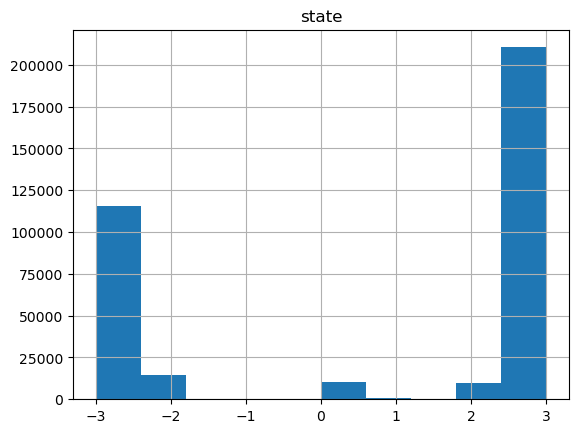

In [30]:
df_cluster_copy.hist(column = 'state', grid = True)

array([[<Axes: title={'center': 'category'}>]], dtype=object)

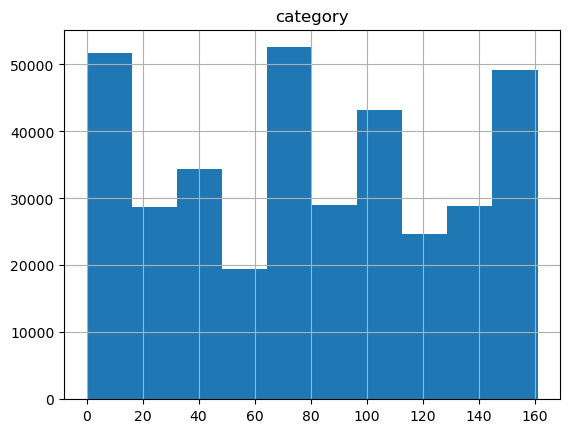

In [31]:
df_cluster_copy.hist(column = 'category', grid = True)

In [32]:
df_cluster_copy.head(2)

,backers_count,category,fx_rate,pledged,state,goal_usd,pledged_usd
0,230.0,11,1.238278,6746.0,3.0,2475.318022,8353.424400
1,34.0,11,1.238278,1079.0,3.0,247.655630,1336.102124


In [33]:
df_cluster_copy.to_csv("./kickstarter-sentiment-analysis_usd-numerical-clustering-dataset.csv", index = False)

In [34]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [35]:
df_cluster = pd.read_csv("./kickstarter-sentiment-analysis_usd-numerical-clustering-dataset.csv")

In [36]:
df_cluster = df_cluster.dropna(axis = 0)

In [65]:
def silhouette_plot(silhouette_values, silhouette_average, labels):
    
    fig, ax = plt.subplots();
    fig.set_size_inches(6,6);
    
    ax.set_xlim([-0.1, 1.0]);
    ax.set_ylim([0, len(silhouette_values) + (len(set(labels)) + 1) * 10])
    
    cluster_plot_lower_y_value = 10;
    for label_value in list(set(labels)):
        label_n_silhouette_values = sorted([silhouette_values[i] for i in range(len(labels)) if labels[i] == label_value]);
        
        size_of_n_cluster = len(label_n_silhouette_values);
        cluster_plot_upper_y_value = cluster_plot_lower_y_value + size_of_n_cluster
        
        color = cm.nipy_spectral(float(label_value/len(set(labels))));
        plt.fill_betweenx(np.arange(cluster_plot_lower_y_value, cluster_plot_upper_y_value),
                          0,
                          label_n_silhouette_values,
                          facecolor = color,
                          edgecolor = color,
                          alpha = 0.7)
        
        ax.text(-0.05, cluster_plot_lower_y_value + 0.5*size_of_n_cluster, str(label_value));        
        cluster_plot_lower_y_value = cluster_plot_upper_y_value + 10;              
        
    ax.axvline(x=silhouette_average, color = "red", linestyle = "--");

    ax.set_yticks([]);
    ax.set_xticks([-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]);

    ax.set_ylabel("cluster assignment", rotation = 45, horizontalalignment = 'right')
    ax.set_xlabel("silhouette score");
    ax.set_title("silhoutte plot for {} clusters".format(len(set(labels))));
                                                    
    return fig, ax    

In [66]:
def scale_data(df_in, sample_fraction = 0.1):
    
    df_in = df_in.sample(frac = sample_fraction)
    
    scaler = StandardScaler();
    
    transformed_data = scaler.fit_transform(df_in.values)
    df_transformed = pd.DataFrame(columns = df_in.columns,
                                  data = transformed_data,
                                  index = df_in.index);
    
    return df_transformed;

In [92]:
def k_means_processing(df_in, n_clusters):
    
    kmeans = KMeans(n_clusters = n_clusters, n_init = 1, init = 'k-means++')
    
    model = kmeans.fit(df_in);
    cluster_labels = model.predict(df_in);
    
    silhouette_average = silhouette_score(df_in, cluster_labels);
    silhouette_values = list(silhouette_samples(df_in, cluster_labels).flatten());
    
    df_labels = df_in.copy()
    df_labels.loc[:,'labels_' + str(n_clusters) + '_clusters'] = cluster_labels;
    
    return df_in, df_labels, model, cluster_labels, silhouette_values, silhouette_average

#### 3.1 K-means Fitting

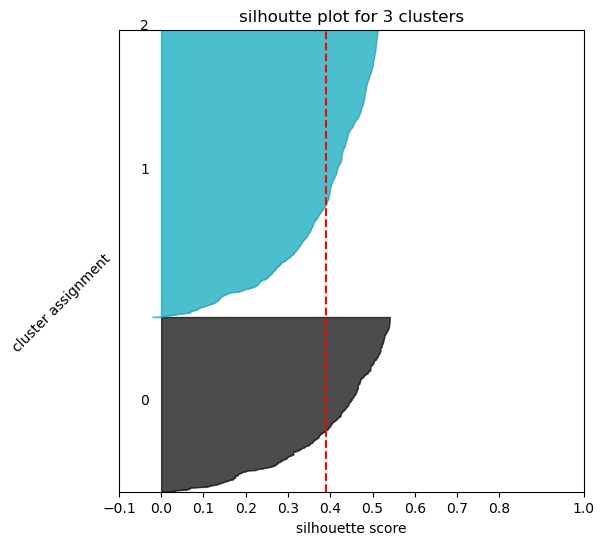

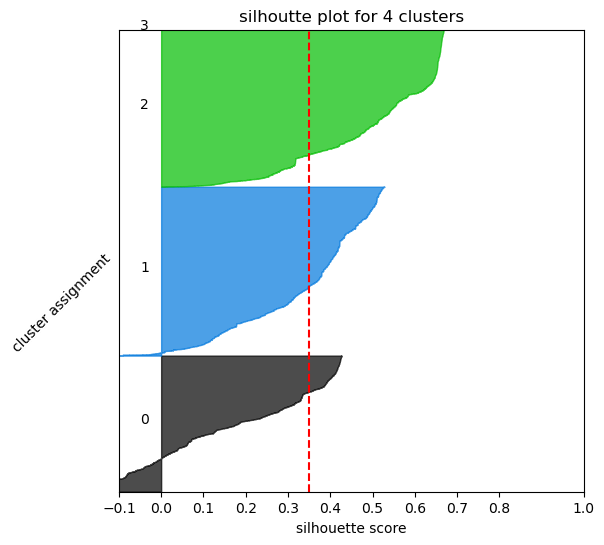

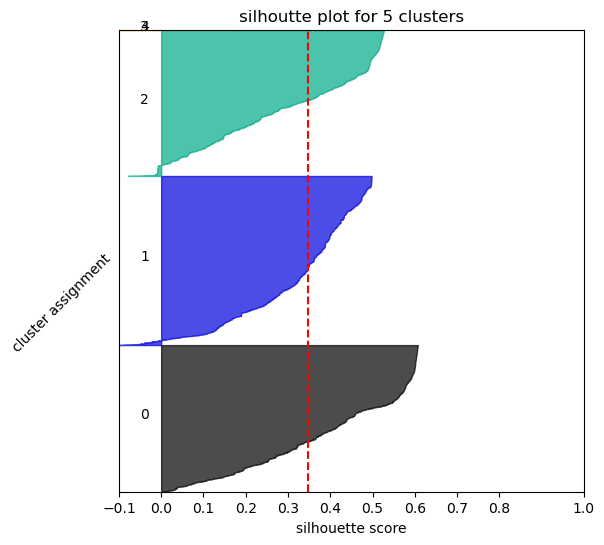

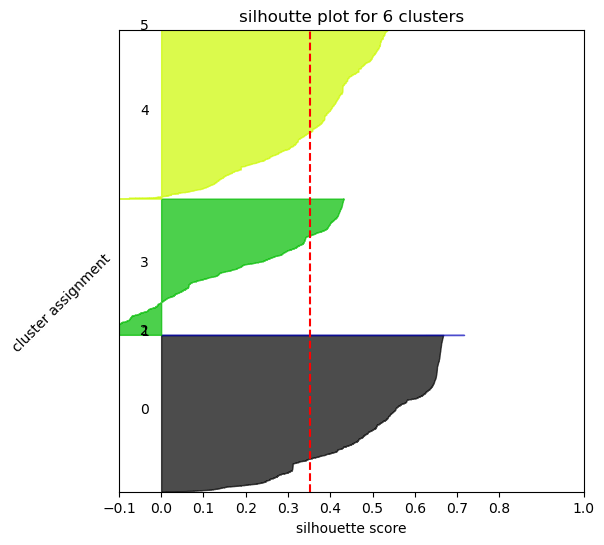

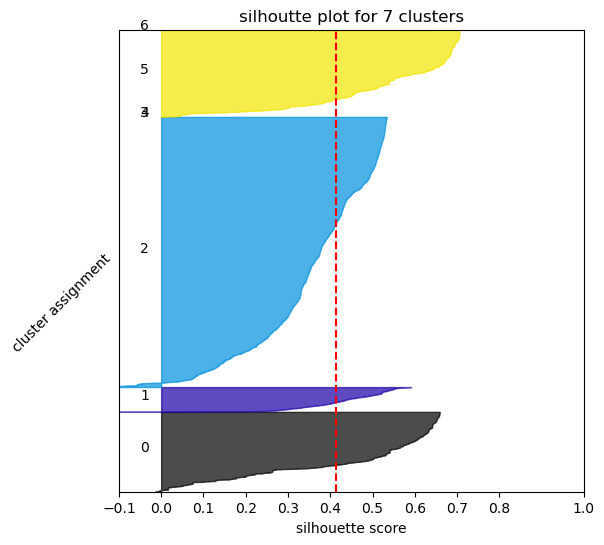

In [93]:
model_dict = {}
number_clusters_to_try = [3, 4, 5, 6, 7]
df_cluster_scaled = scale_data(df_cluster, sample_fraction = .25)
for number_clusters in number_clusters_to_try:
    df_cluster_scaled, df_cluster_labeled, kmeans_model, cluster_labels, silhouette_values, silhouette_average = k_means_processing(df_cluster_scaled, number_clusters)
    
    model_dict.update({number_clusters : kmeans_model})
    
    silhouette_plot(silhouette_values, silhouette_average, cluster_labels)

In [336]:
df_label = df_cluster.copy()
df_label.loc[:, 'label'] = model_dict[3].predict(pd.DataFrame(StandardScaler().fit_transform(df_cluster), columns = df_label.columns))

In [337]:
df_label.to_csv('./kickstarter-sentiment-analysis_3-labeled-data-frame.csv', index = False)

In [287]:
df_label.head(2)

,backers_count,category,fx_rate,pledged,state,goal_usd,pledged_usd,label
0,230.0,11,1.238278,6746.0,3.0,2475.318022,8353.424400,1
1,34.0,11,1.238278,1079.0,3.0,247.655630,1336.102124,1


### 4.0 Analysis

#### 4.1 Exploration

##### Now the data are partitioned (with the clustering algorithm) and the langage data has been incorporated into that partitioning in a ration way, I will reimport the data under a different variable name and complete the exploratory analysis.

In [213]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import pickle
import ast

In [2]:
# Here I define a simple function to calculate the mode of an array.

def custom_mode(data):
    count_dict = {}
    for value in data:
        if value not in count_dict.keys():
            count_dict.update({value : 1});
        else:
            count_dict[value] += 1;
        
    count_dict = sorted(count_dict.items(), key = lambda x : x[1], reverse = True)
    
    return count_dict[0][0]

In [3]:
# Here I define a function that allows me to round to the nearest order of magnitude (power): i.e. 1230 -> 1200 for power of two

def custom_round(data, power):
    data_copy = data.copy();
    for index, value in enumerate(data):
         data_copy[index] = round(value/(10**power))*(10**power);
            
    return data_copy;      

In [169]:
# Here I define a plotting function where I can look at histograms or bar plots of the features within each cluster.

def custom_plot(data, feature, plotType = 'hist', number_clusters = 3, sharex = True, 
                number_columns = 3, round_digits = 2, figsize = (24, 8), number_bins = 60,
                xbounds = [], ybounds = [], fontfamily = 'arial', fontweight = 'bold', fontsize = 20, top_n = 0):

    font = {'family' : fontfamily,
            'weight' : fontweight,
            'size'   : fontsize}

    matplotlib.rc('font', **font)
    
    number_rows = int(np.ceil(number_clusters/number_columns));
    fig, axs = plt.subplots(nrows = number_rows, ncols = number_columns, figsize = figsize, layout = 'constrained')
    fig.suptitle(feature + " by cluster", x = 0.0);
    
    if (plotType == 'hist'):
        for index, ax in enumerate(axs):
            hist_data = data.loc[data['label'] == index , :]
            hist_data = hist_data.loc[:, feature].values;
            
            mean = np.mean(hist_data)
            std = np.std(hist_data)
            
            hist_data = [i for i in hist_data if (i <= mean + 2 * std) and (i >= mean - 2 * std)]
                         
            if xbounds:
                hist_data = [i for i in hist_data if (i >= xbounds[index][0]) and (i <= xbounds[index][1])]
                mean = np.mean(hist_data)
                std = np.std(hist_data)
            
            color = cm.nipy_spectral(float(index/number_clusters))                          
            ax.hist(hist_data, number_bins, facecolor = color, edgecolor = 'k', alpha = 0.7)                           
            
            ax.tick_params(rotation = 45, labelsize = fontsize)
            ax.set_title("cluster {} \n mean of ".format(index) + feature + " = {:.1f} (red) \n".format(mean));
      
            ax.set_xlabel(feature, fontsize = fontsize)
            ax.set_ylabel('counts', fontsize = fontsize)             
            
            ax.set_xticks(ax.get_xticks());
            ax.set_yticks(ax.get_yticks());
            
            ax.set_xticklabels(ax.get_xticklabels(), ha = 'right');
            ax.set_yticklabels(ax.get_yticklabels(), va = 'top');          
            
            if ybounds:
                ylims = ybounds[index];
            else:
                ylims = ax.get_ylim();
            
            ax.vlines(mean, ylims[0], ylims[1], colors = 'r')
            
            ax.set_ylim(bottom = ylims[0], top = ylims[1]);
            
    elif (plotType == 'bar'):
        for index, ax in enumerate(axs):
            bar_data = sorted(data.loc[data['label'] == index, feature].values)
    
            feature_type_count = {};
            for value in bar_data:
                if value not in feature_type_count.keys():
                    feature_type_count.update({value : 1});
                else:
                    feature_type_count[value] += 1;
    
            sorted_feature_type_count = sorted(feature_type_count.items(), key = lambda x : x[1], reverse = True)
            if top_n != 0:
                feature_type_count = dict(sorted_feature_type_count[0:top_n]);
                percent_data_accounted_for = round(100*(sum([i[1] for i in sorted_feature_type_count[0:top_n]])/sum([i[1] for i in sorted_feature_type_count]))) 
            else:
                feature_type_count = dict(sorted_feature_type_count);
                percent_data_accounted_for = 100.0;
    
            keys = feature_type_count.keys();
            values = feature_type_count.values();
    
            color = cm.nipy_spectral(float(index/number_clusters))    
            ax.bar(keys, values, facecolor = color, edgecolor = 'k', alpha = 0.7, align = 'center')
    
            ax.tick_params(rotation = 45, labelbottom = True, labelsize = fontsize)
            ax.set_title("cluster {} \n top_n = {} \n {} % of data accounted for".format(index, top_n, percent_data_accounted_for));          
        
            ax.set_xlabel(feature, fontsize = fontsize)
            ax.set_ylabel('counts', fontsize = fontsize)
            
            ax.set_xticks(ax.get_xticks());
            ax.set_yticks(ax.get_yticks());
            
            ax.set_xticklabels(ax.get_xticklabels(), ha = 'right');               
            ax.set_yticklabels(ax.get_yticklabels(), va = 'top');
                       
    return fig, axs

In [92]:
df_label = pd.read_csv('./kickstarter-sentiment-analysis_3-labeled-data-frame.csv')

In [93]:
df_mixed = pd.read_csv('./kickstarter-sentiment-analysis_usd-preprocessed-with-sentences.csv').dropna()

In [94]:
df_mixed.loc[:, 'label'] = np.nan;
for index, row in df_mixed.iterrows():
    if index in df_label.index:
        df_mixed.loc[index, 'label'] = df_label.loc[index, 'label']

In [95]:
df_mixed.loc[:, 'pledged-goal'] = df_mixed['pledged_usd'] - df_mixed['goal_usd']

In [162]:
df_mixed.head(2)

,backers_count,category,fx_rate,state,sentences,goal_usd,pledged_usd,label,pledged-goal
0,230.0,Software,1.238278,successful,"['cisco', 'ccna', 'and', 'ccna', 'security', '...",2475.318022,8353.424400,1.0,5878.106378
1,34.0,Software,1.238278,successful,"['strong', 'file', 'encryption', 'tool', 'stro...",247.655630,1336.102124,1.0,1088.446494


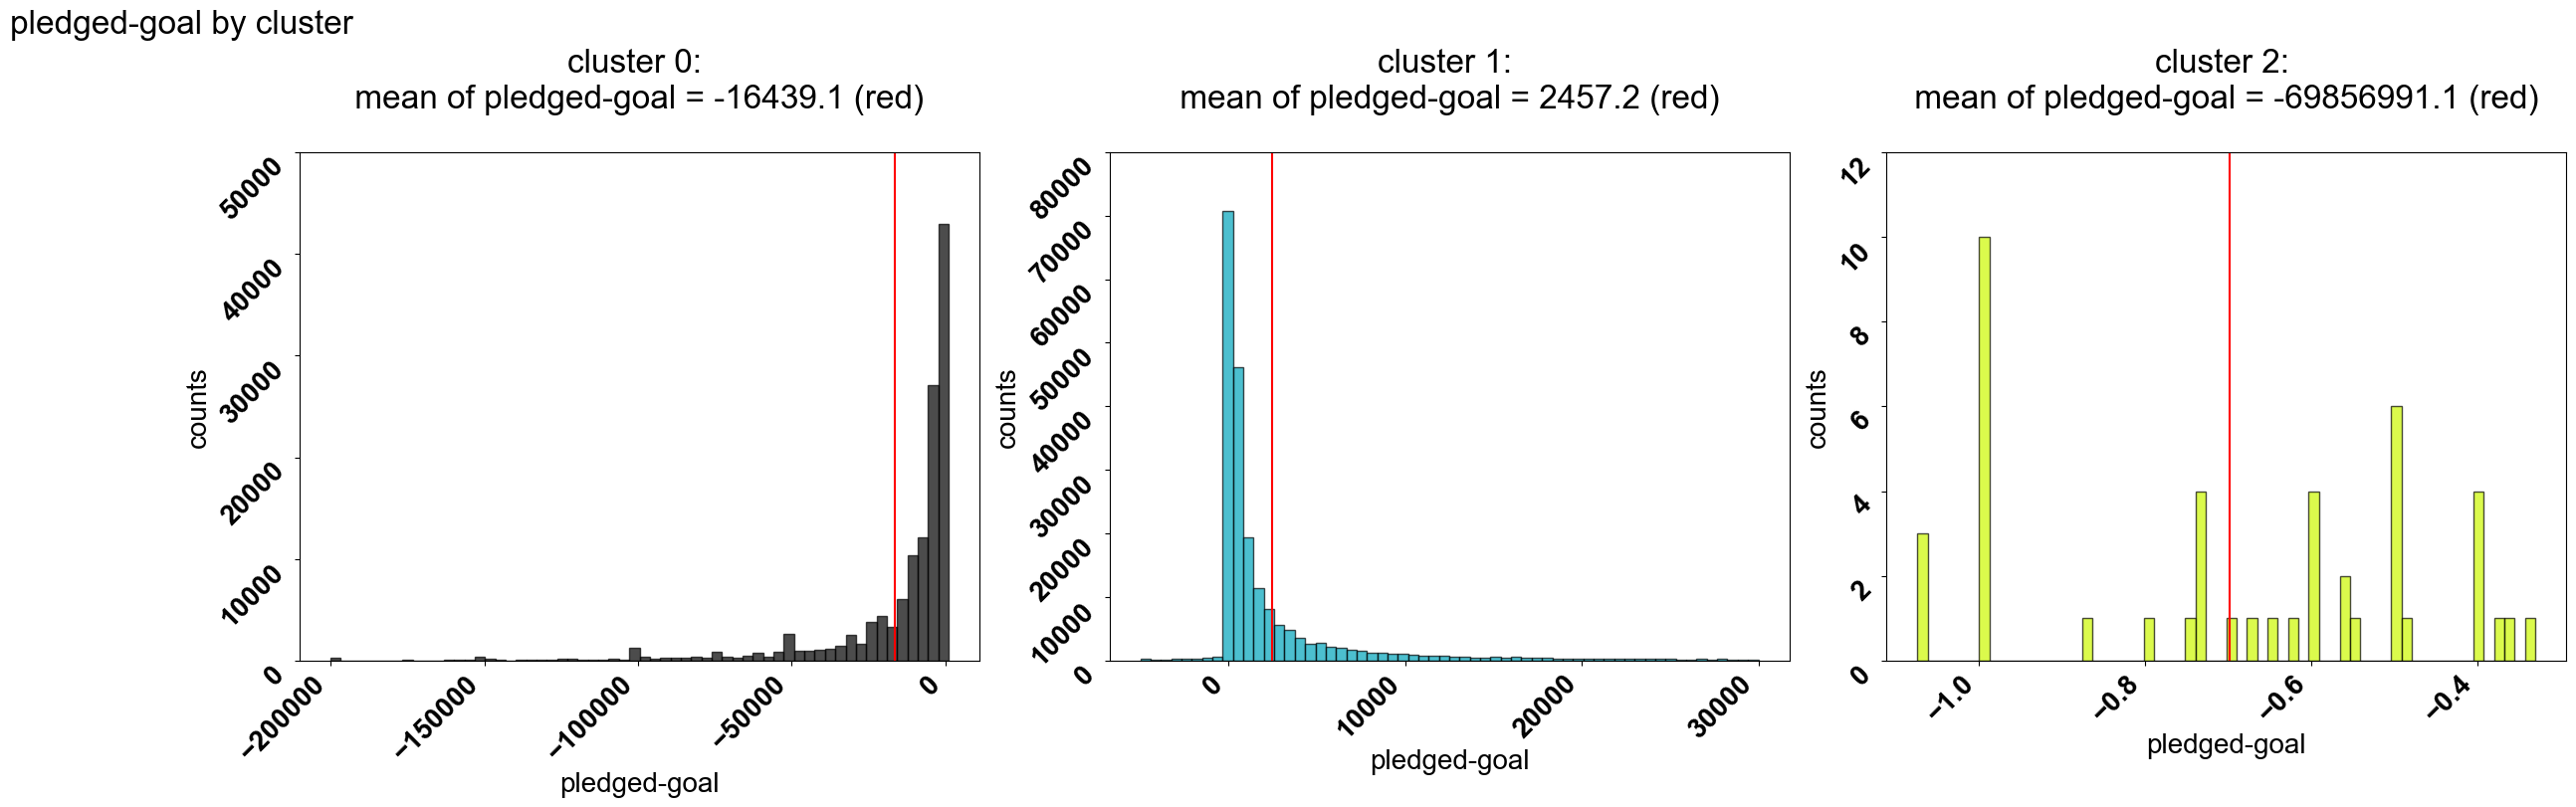

In [172]:
fig1, axs1 = custom_plot(df_mixed, 'pledged-goal' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(-200000, .01e5), (-5000, 30000), (-1.1e8, 0)], fontsize =  20)

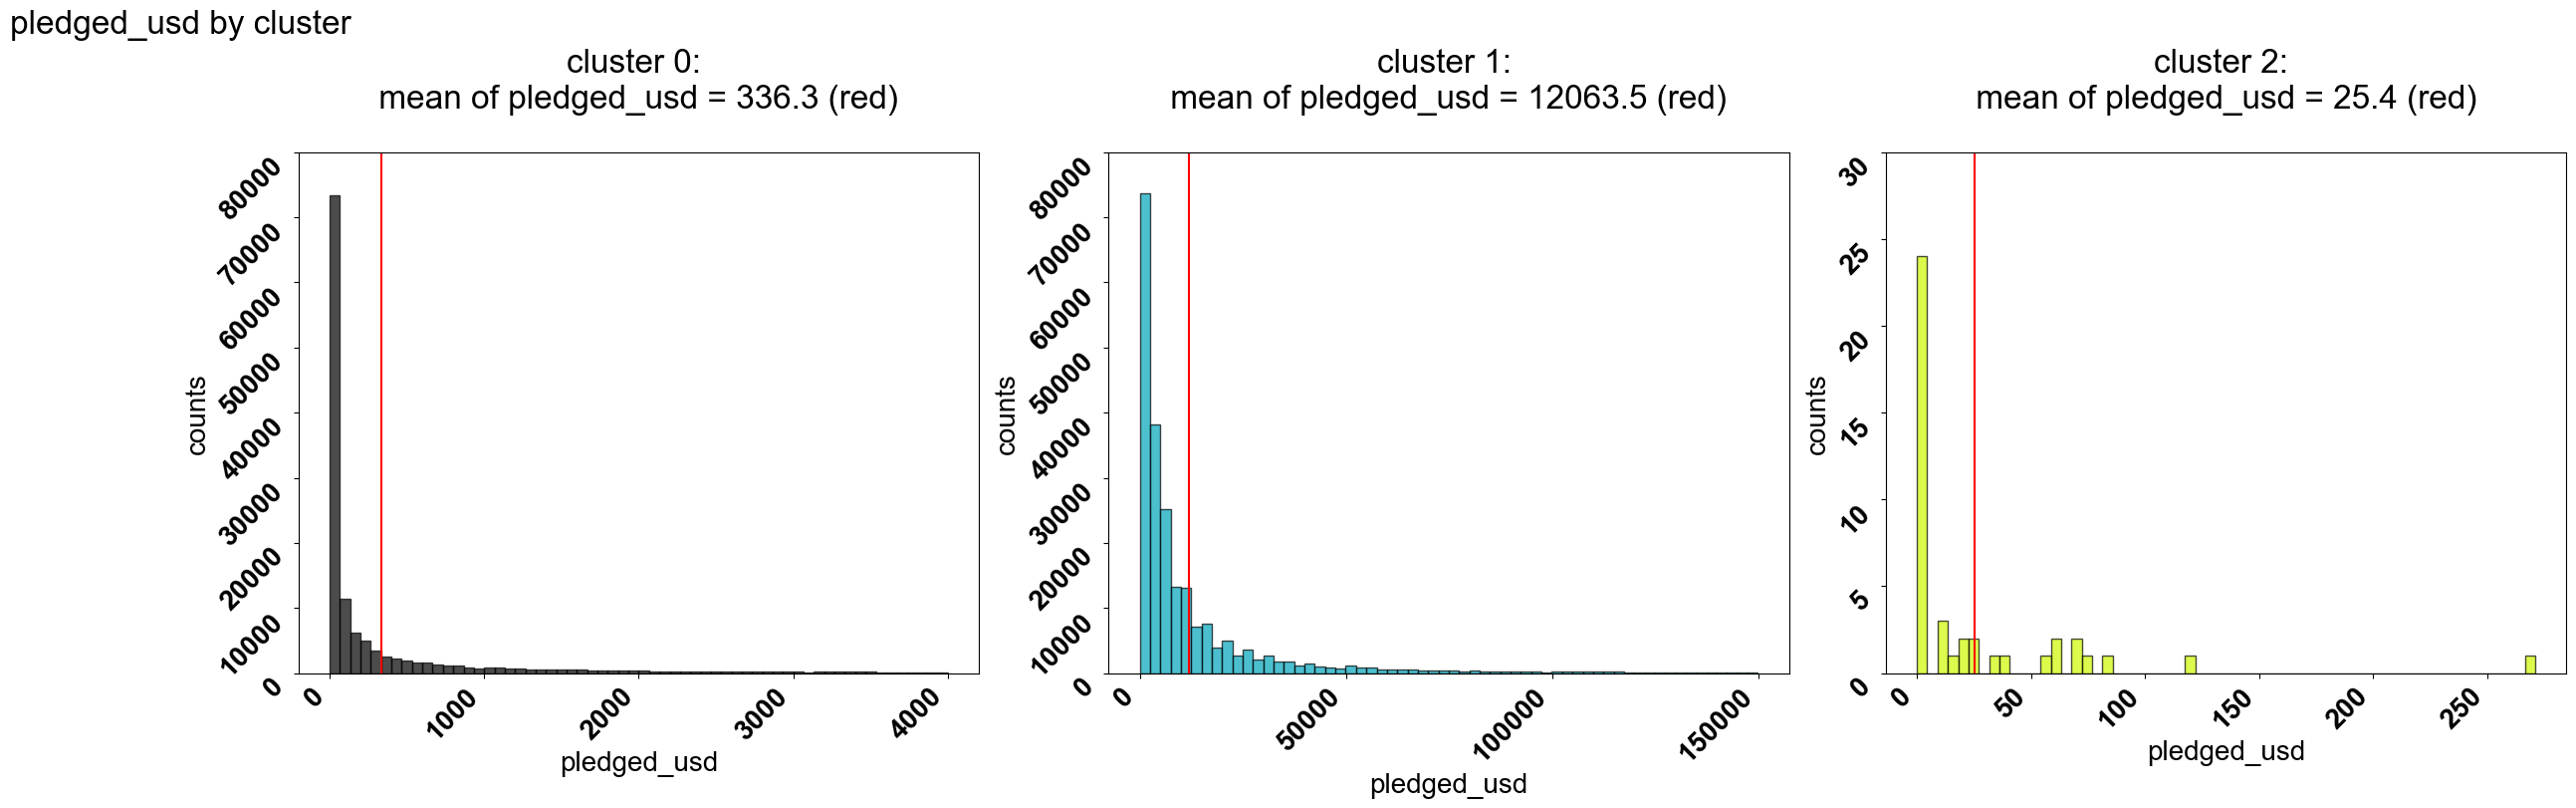

In [173]:
fig2, axs2 = custom_plot(df_mixed, 'pledged_usd' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, 4000), (0, 150000), (0, 400)], fontsize = 20)

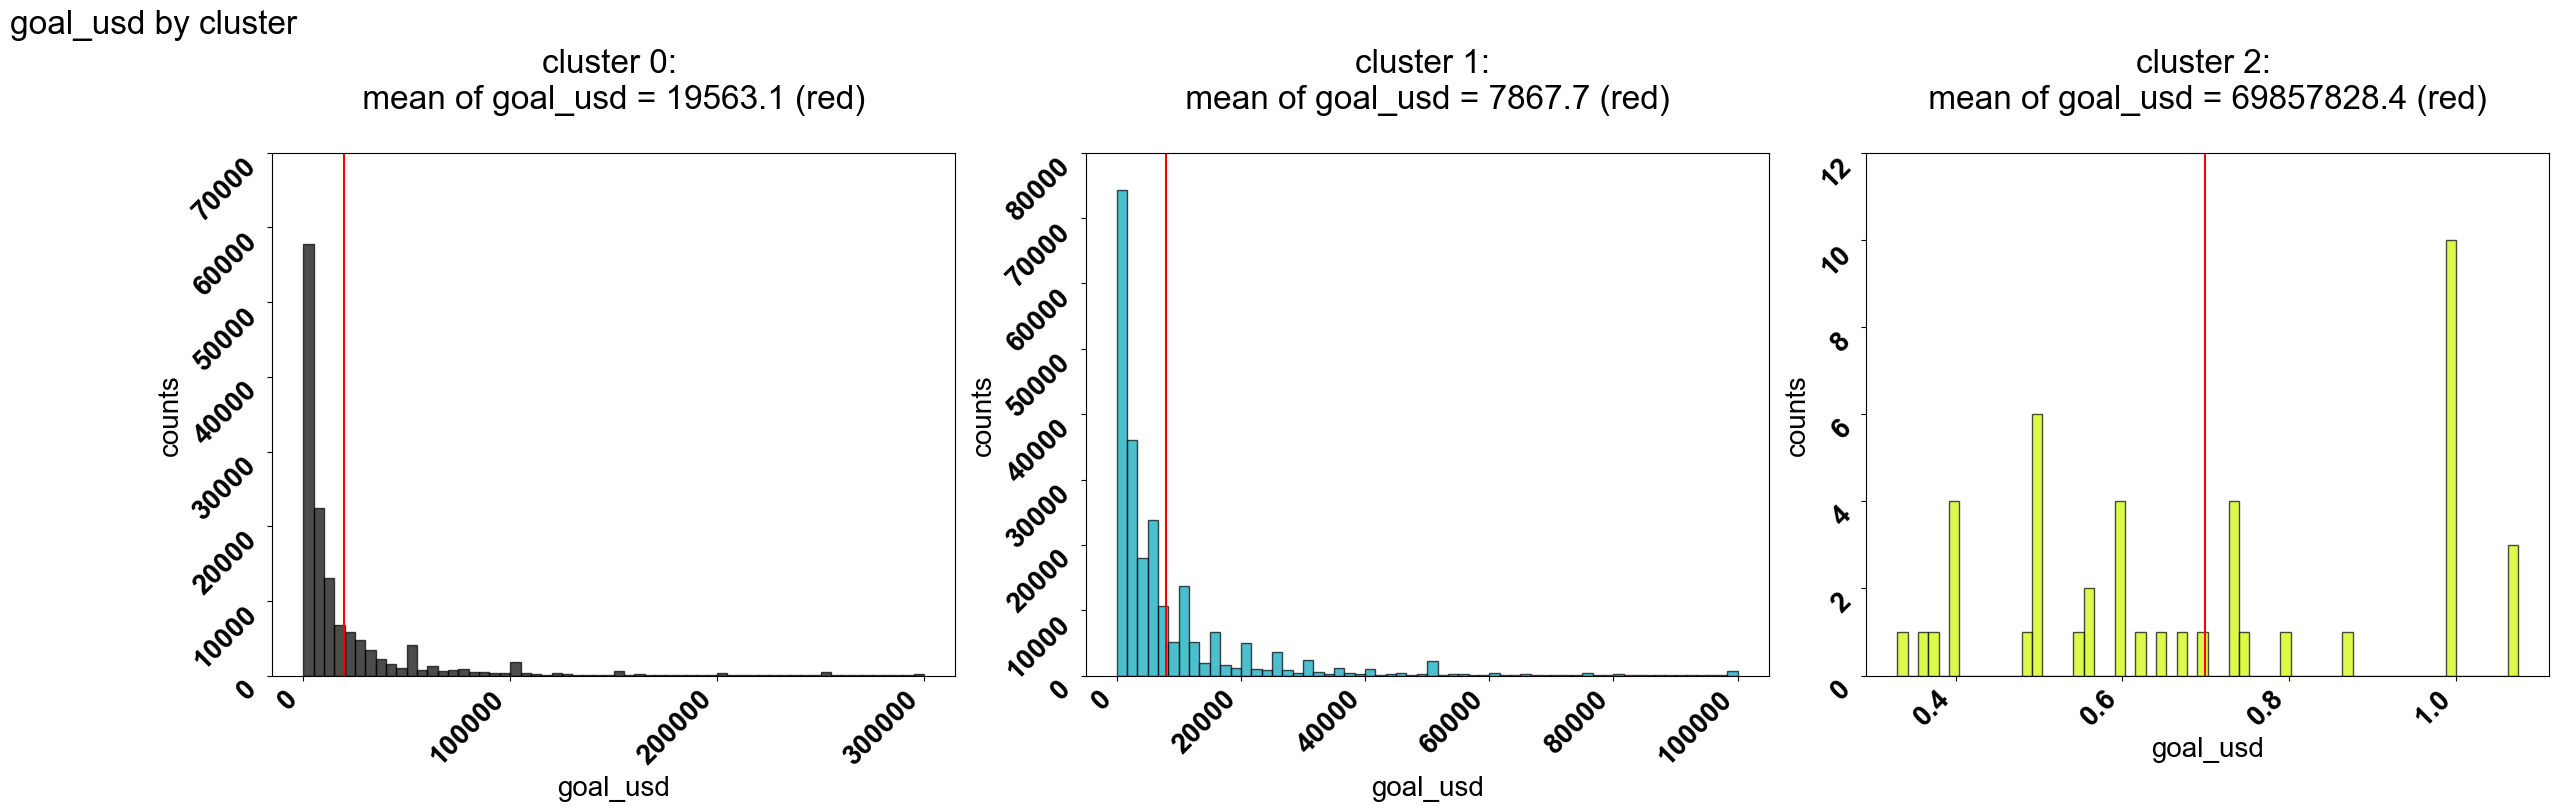

In [174]:
fig3, axs3 = custom_plot(df_mixed, 'goal_usd' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, .3e6), (0, 100000), (0, 1.1e8)], fontsize = 20)

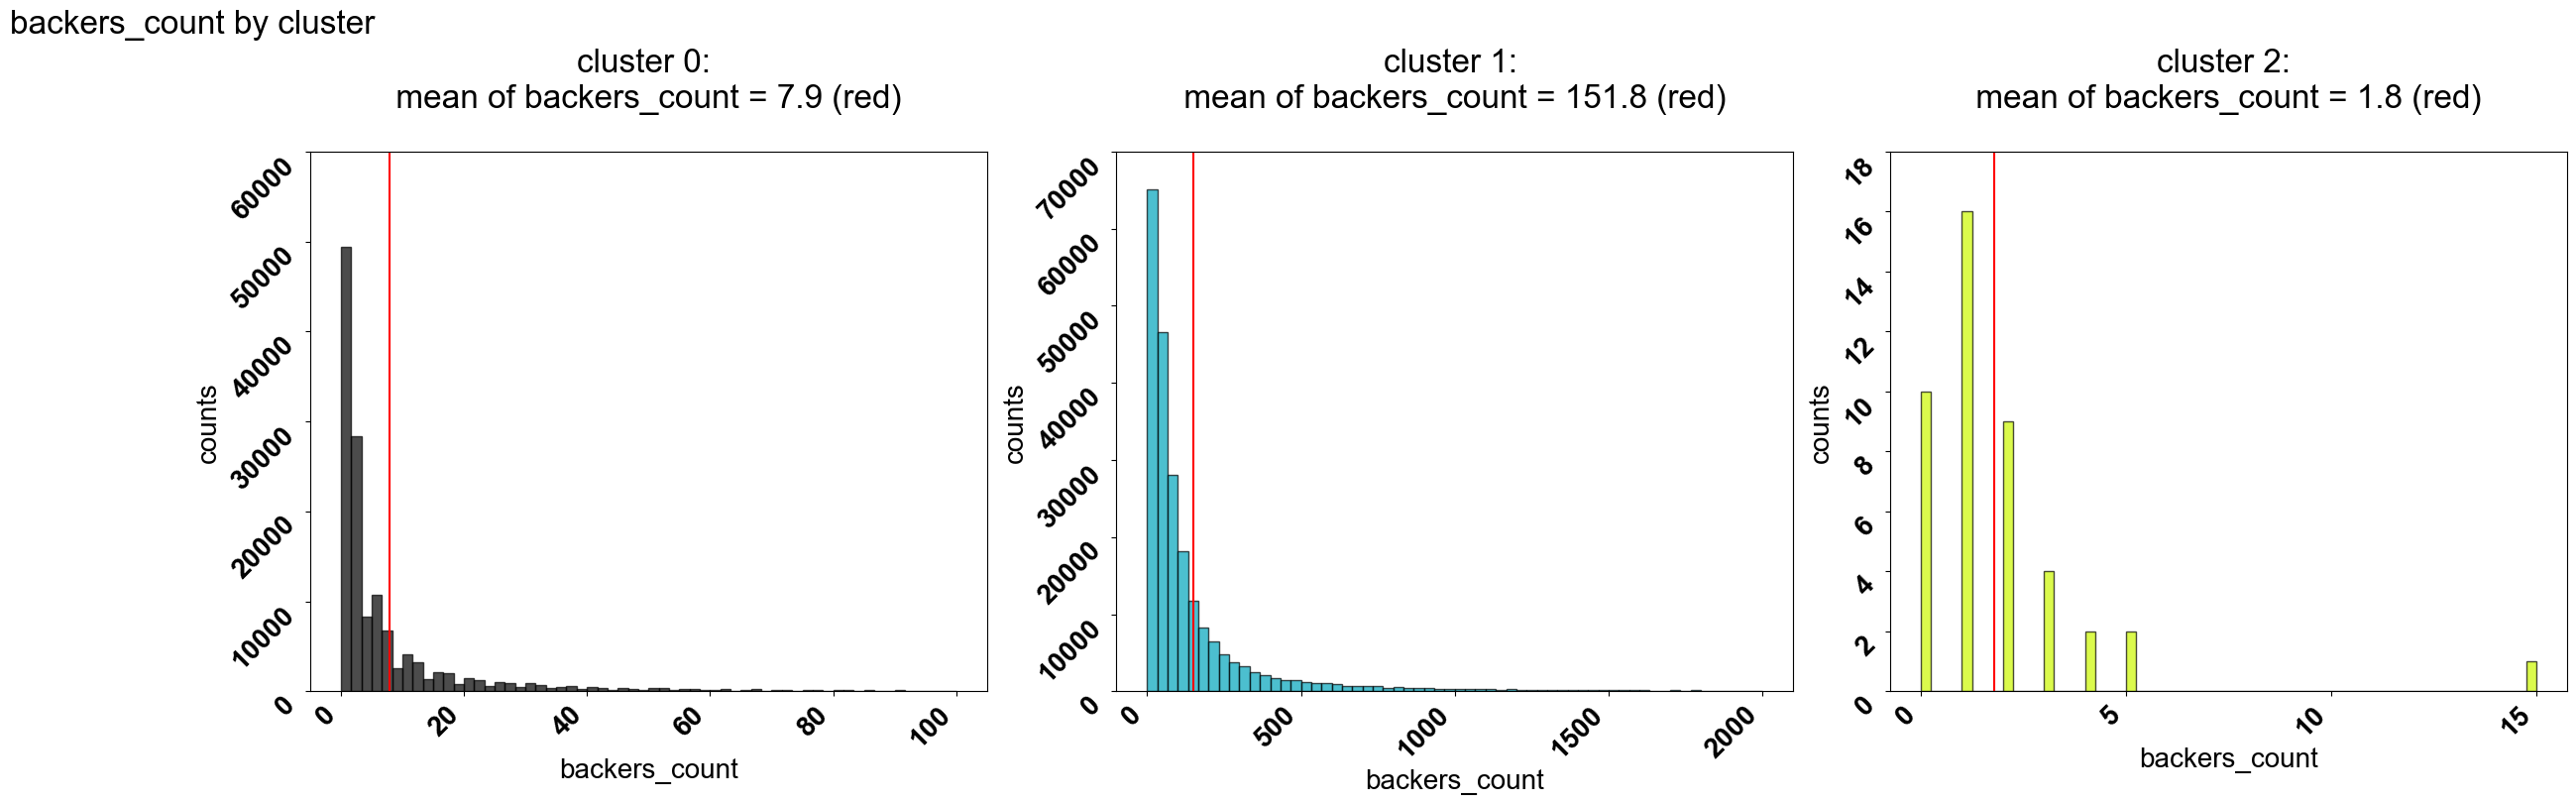

In [175]:
fig4, axs4 = custom_plot(df_mixed, 'backers_count' ,plotType = 'hist', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, 100), (0, 2000), (0, 15)], fontsize = 20)

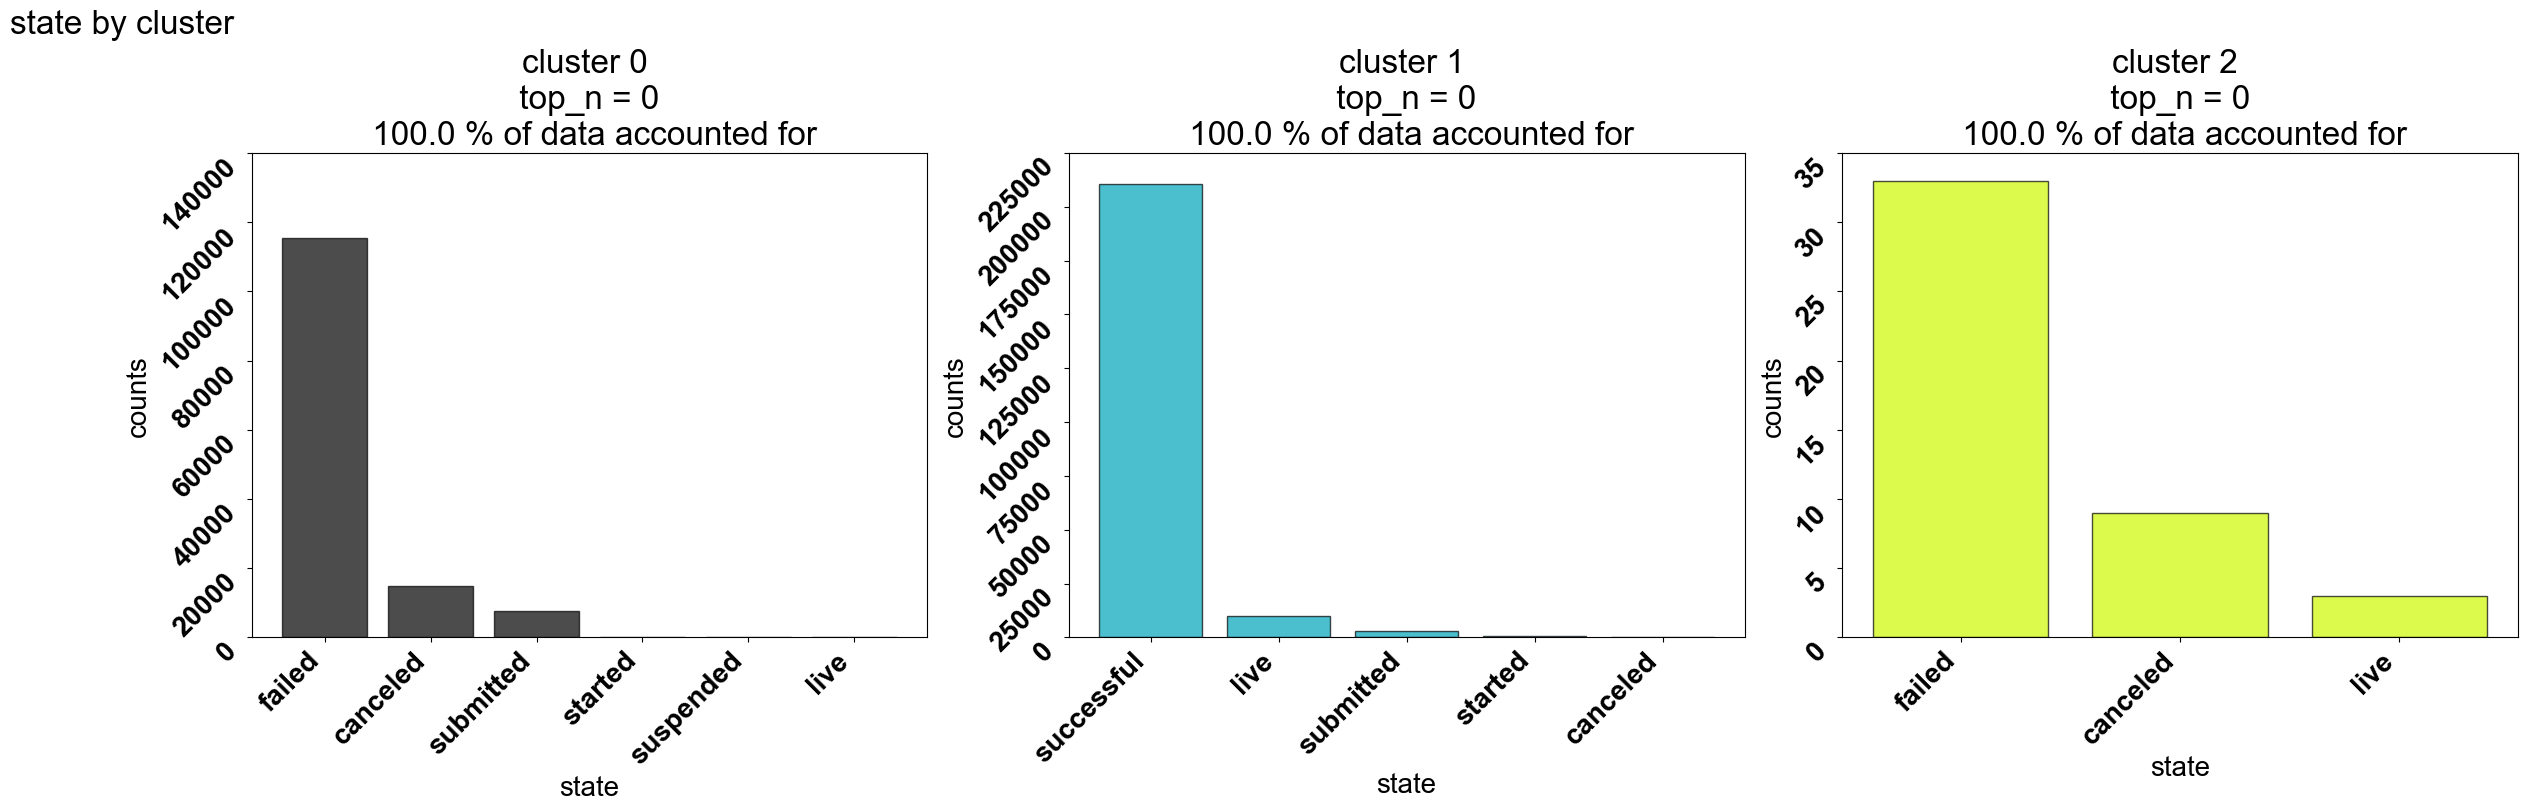

In [176]:
fig4, axs4 = custom_plot(df_mixed, 'state' ,plotType = 'bar', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (24, 8),
                         xbounds = [(0, 100), (0, 2000), (0, 15)], fontsize = 20)

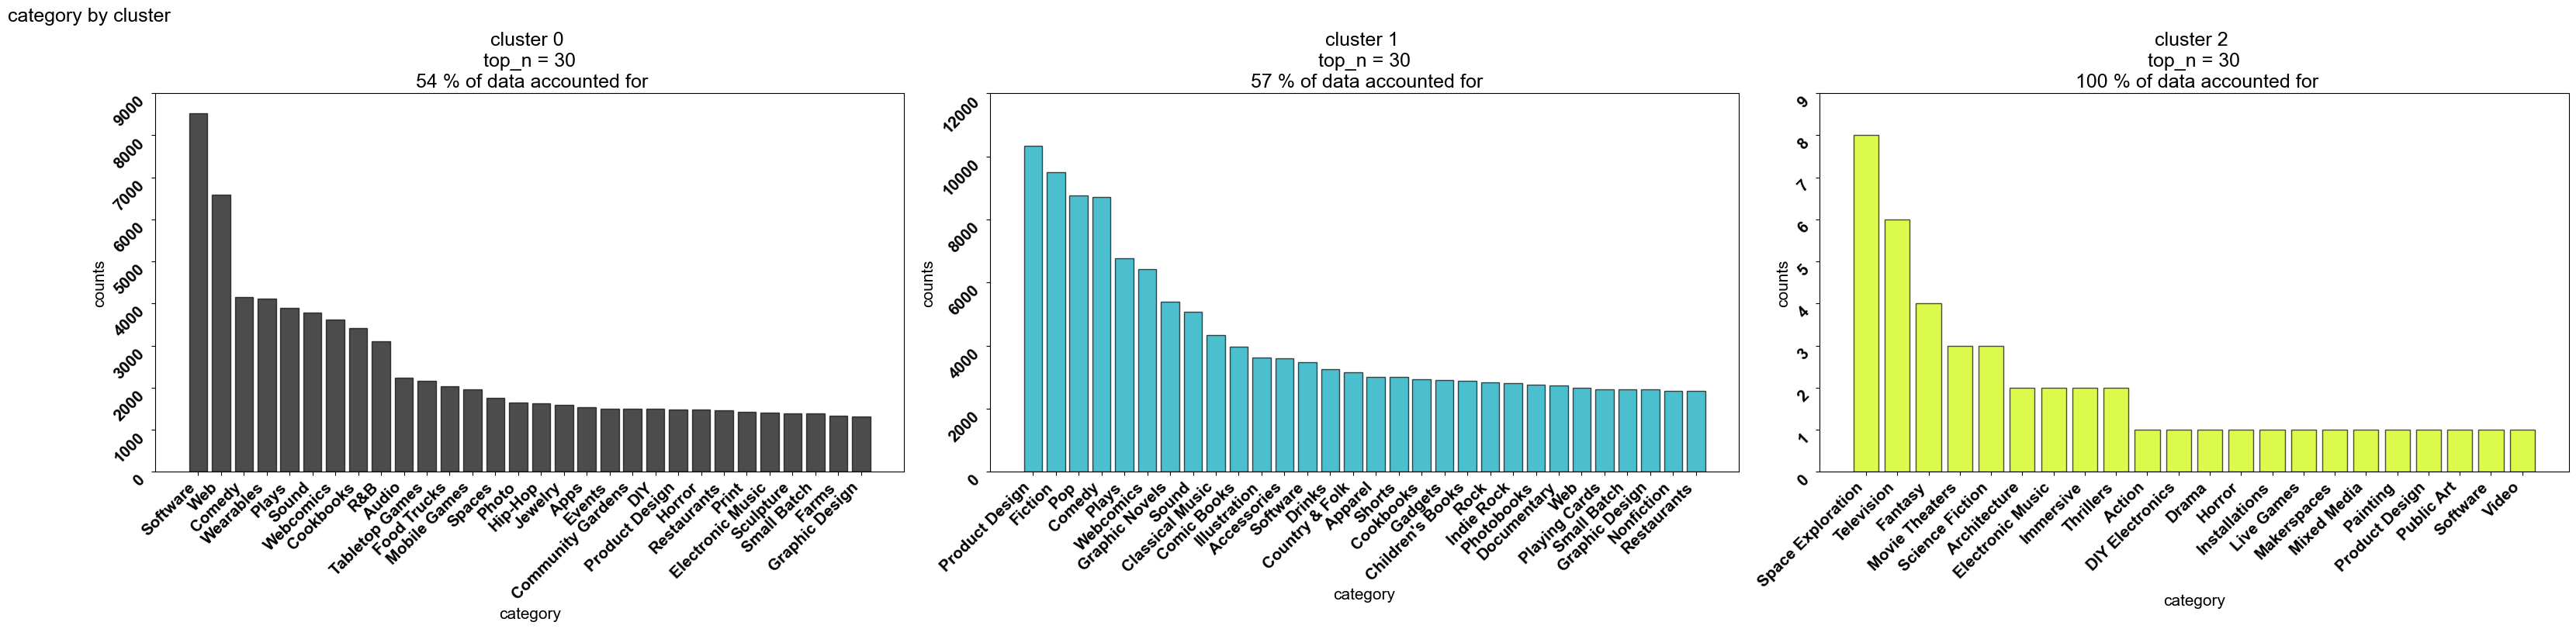

In [177]:
fig4, axs4 = custom_plot(df_mixed, 'category' ,plotType = 'bar', number_clusters = 3, number_columns = 3, round_digits = 4, figsize = (32, 8),
                         xbounds = [(0, 100), (0, 2000), (0, 15)], fontsize = 15, top_n = 30)

In [218]:
# Now I'm going to do a word frequency analysis for each of the three clusters. 

# This cell will calculate the word frequencies for each cluster and store these in 
# a dictionary called word_frequencies. I am using a standard nested dictionary
# counting method for this.

word_frequencies = {}
labels = list(df_mixed['label'].unique());
for index, row in df_mixed.iterrows():
    sentence = [i.strip() for i in ast.literal_eval(row['sentences'])];
    if row['label'] not in word_frequencies.keys():
        word_frequencies.update({row['label'] : {}});
        for word in sentence:
            if word not in word_frequencies[row['label']].keys():
                word_frequencies[row['label']].update({word : 1});
            else:
                word_frequencies[row['label']][word] += 1;
                
    else:
        for word in sentence:
            if word not in word_frequencies[row['label']].keys():
                word_frequencies[row['label']].update({word : 1});
            else:
                word_frequencies[row['label']][word] += 1;

In [220]:
# I am going to pickle and save this so that I don't have to redo the fequency count
# later.

with open('./kickstarter-sentiment-analysis_word-frequencies.pickle', 'wb') as handle:
    pickle.dump(word_frequencies, handle);

In [245]:
# Here I will define a plotting function that plots the top_n most frequent words for 
# each cluster. I am going to import gensims STOPWORDS frozen list to use as a reference
# to exclude stop words.

from gensim.parsing.preprocessing import STOPWORDS as stopwords
custom_stopwords = ['new'];

def custom_word_frequency_plot(word_frequencies, number_columns = 3, figsize = (24, 8), top_n = 0, fontsize = 20):
    
    cluster_labels = word_frequencies.keys();
    number_clusters = len(cluster_labels);
    
    number_rows = int(np.ceil(number_clusters/number_columns));
    fig, axs = plt.subplots(nrows = number_rows, ncols = number_columns, figsize = figsize, layout = 'constrained');
    
    for index, ax in enumerate(axs):
        
        # remove any stopwords using the filter function.
        filtered_words = filter(lambda x : (x[0] not in stopwords) and (x[0] not in custom_stopwords), word_frequencies[index].items())
        sorted_words = sorted(filtered_words, key = lambda x : x[1], reverse = True)
        if top_n > 0:
            sorted_words = sorted_words[0:top_n];
        unzipped = list(zip(*sorted_words));
        
        words = unzipped[0];
        values = unzipped[1];
        
        color = cm.nipy_spectral(float(index/number_clusters))    
        ax.bar(words, values, facecolor = color, edgecolor = 'k', alpha = 0.7, align = 'center')
        
        ax.tick_params(rotation = 45, labelbottom = True, labelsize = fontsize)
        ax.set_title("cluster {}".format(index));          
        
        ax.set_xlabel('words', fontsize = fontsize)
        ax.set_ylabel('counts', fontsize = fontsize)
            
        ax.set_xticks(ax.get_xticks());
        ax.set_yticks(ax.get_yticks());
            
        ax.set_xticklabels(ax.get_xticklabels(), ha = 'right');               
        ax.set_yticklabels(ax.get_yticklabels(), va = 'top');
        
    return fig, axs

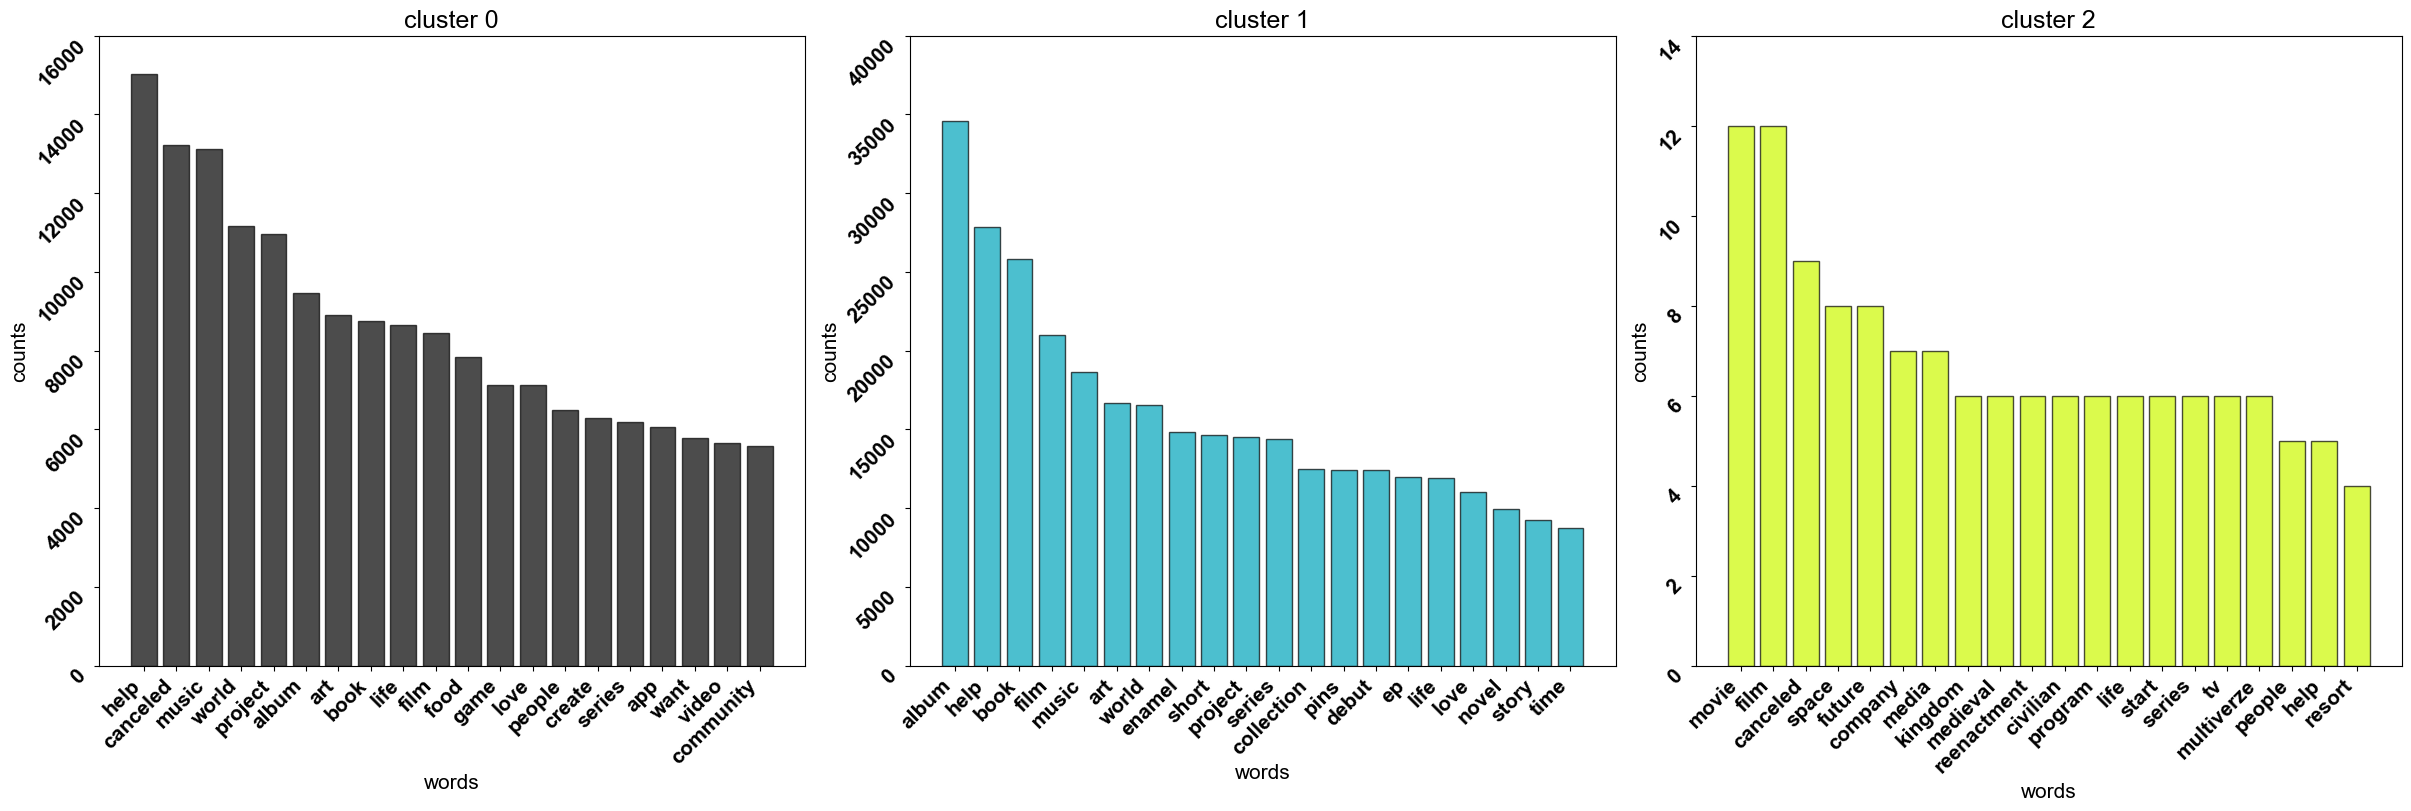

In [250]:
custom_word_frequency_plot(word_frequencies, number_columns = 3, figsize = (24, 8), top_n = 20, fontsize = 15);

In [252]:
# As one final step I want to see how different words are predictive of over and under achievement of a goal.
# Since almost all of the projects in cluster zero underachieved and almost all of the projects
# in cluster 1 overachieved I will use those clusters respectively for understanding under and over-achievement.

# To get this information I will embed all of the words in the sentence corpus in a 2 dimensional vector space
# using word2vec. Then I will run a linear regression with l2 regularization on the embedded data. This will 
# give a plane with two independent variables. The dependent variable will be value of pledged - goal. 

# I will choose a set number of values for over/under achievement and look for the 2d word embeddings that
# are lie closes to a line defined by the intersection of the regression plane and a plane for which the value
# of over/under achievement is constant.